# Tutorial: Sentiment Analysis with LASER Embeddings and RNN

In this tutorial, we will guide you through the process of installing the necessary libraries, downloading a sentiment analysis dataset, and building a sentiment analysis model using [LASER](https://github.com/facebookresearch/LASER) embeddings and a Recurrent Neural Network (RNN).



## Step 1: Installing Laser Encoder

To begin, let's install the laser_encoders library along with its dependencies. These include sacremoses, sentencepiece, and fairseq. You can achieve this by running the following command:

In [1]:
! pip install laser_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.1/895.1 kB 20.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 103.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.9/279.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fairseq: filename=fairseq-0.12.2-cp310-cp310-linux_x86_64.whl size=11291822 sha256=f284b2bd281d73f4627eebec8246219b367d69be6daf1c998492c80ec41dca9a

This ensures that you have all the required packages for this tutorial.

## Step 2: Install Additional Libraries

Before we proceed, let's install the chardet library, which is handy for detecting the encoding of the dataset.

In [2]:
!pip install chardet

With chardet installed, we can confidently handle various dataset encodings.

## Step 3: Connect to your drive

To access files from your Google Drive, mount it using the following code.



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 4: Import Necessary Libraries

Now, let's import the libraries required for data manipulation, encoding, and model building.

In [4]:
import numpy as np
import pandas as pd
import chardet
import matplotlib.pyplot as plt
from laser_encoders import LaserEncoderPipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tqdm import tqdm

These libraries will be crucial for various stages of the tutorial.

## Step 5: Load the Dataset

These lines enable you to connect to your Google Drive, access the dataset, and ensure proper encoding for reading the CSV file. To download the dataset, follow these steps:

- Go to this Kaggle link: [Sentiment analysis dataset](https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset)
- Download the dataset and unzip it.



```
!unzip -q /path/to/downloaded/dataset.zip -d /dataset/folder
```



- Use the train.csv file for your sentiment analysis project.

We'll load the sentiment analysis dataset, detect its encoding, and select only the relevant columns ('sentiment' and 'text').

In [5]:
with open('/content/drive/MyDrive/dataset/train.csv', 'rb') as f:
    result = chardet.detect(f.read())

# Use the detected encoding when reading the CSV file
data = pd.read_csv('/content/drive/MyDrive/dataset/train.csv', encoding=result['encoding'])
data = data[['sentiment', 'text']]

This ensures that we work with the correct dataset encoding.



## Step 6: Data Processing

Before diving into model training, let's shuffle the dataset for better generalization:

In [6]:
data = data.sample(frac=1)
print(data.head())
print(data.shape)

      sentiment                                               text
7480    neutral  all alone.  still watching TWW, eating Italian...
4446    neutral            It will give me lulz from time to time.
17341  negative  leaving florida want to live there forever! Te...
24201   neutral  working today.  Can`t find my key so I had to ...
21908   neutral                                          WORD!!!!!
(27481, 2)


Shuffling helps prevent any potential biases in the data.



## Step 7:Visualizing Sentiment Distribution in the Dataset

This step involves creating a bar plot to visualize the distribution of sentiments in the dataset.

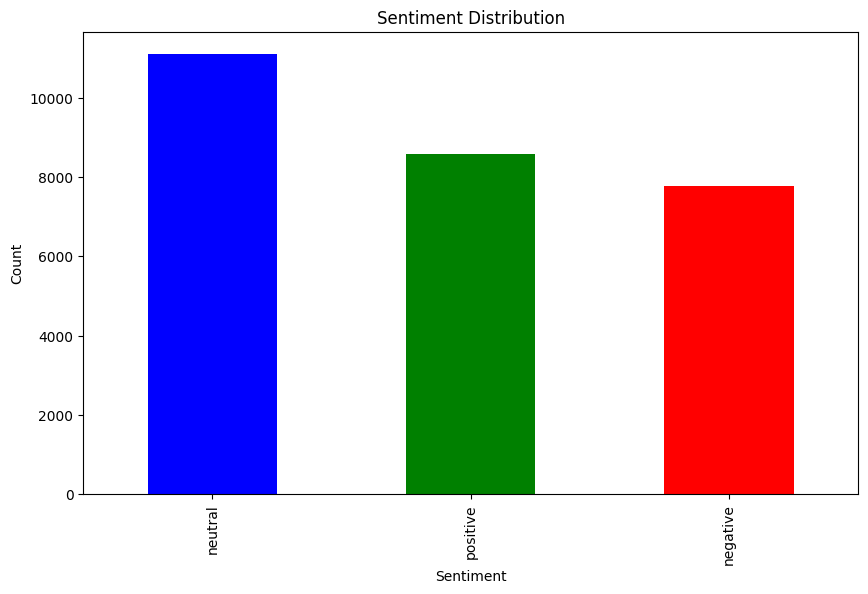

In [7]:
plt.figure(figsize=(10, 6))
data['sentiment'].value_counts().plot(kind='bar', color=['blue', 'green', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

## Step 8: Extract Sentiments and Texts from DataFrame

Now, we'll extract sentiments and texts from the DataFrame and mapp sentiments to numerical values.

Assigning numerical values to Sentiments:
Neutral -> 1
Positive -> 2
Negative -> 3

In [8]:
sentiments = []
texts = []

for index, row in data.iterrows():
    sentiment = row['sentiment'].lower()  # Convert to lowercase for case-insensitivity
    if sentiment == 'neutral':
        sentiments.append(1)
    elif sentiment == 'positive':
        sentiments.append(2)
    elif sentiment == 'negative':
        sentiments.append(3)
    else:
        # Handle the case where sentiment is not one of the expected values
        # You may choose to skip this row or handle it differently based on your requirements
        print(f"Warning: Unknown sentiment '{sentiment}' in row {index}")
        continue  # Skip the rest of the loop for this row

    text = row['text']
    if not isinstance(text, float):
        texts.append(text)
    else:
        # Skip the sentiment for this row as well
        print(f"Warning: Skipping row {index} with float text value")
        sentiments.pop()  # Remove the last added sentiment

print(len(sentiments))
print(len(texts))


27480
27480


This step prepares the data by converting sentiments and texts into a suitable format for training.



## Step 9: Split the Dataset

For model training and evaluation, we'll split the dataset into training and validation sets:

In [9]:
label_encoder = LabelEncoder()
encoded_sentiments = label_encoder.fit_transform(sentiments)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, encoded_sentiments, test_size=0.2, random_state=42)

# Initialize the LaserEncoder
encoder = LaserEncoderPipeline(lang="eng_Latn")

100%|██████████| 1.01M/1.01M [00:00<00:00, 1.27MB/s]
100%|██████████| 179M/179M [00:08<00:00, 21.9MB/s]
100%|██████████| 470k/470k [00:00<00:00, 742kB/s]


A good practice is to reserve a portion of the data for validation to assess the model's performance.

## Step 10: LASER Embeddings

Now, let's leverage LASER embeddings to convert the text data into numerical representations:

In [10]:
# Initialize empty arrays to store embeddings
X_train_embeddings = []
X_test_embeddings = []

# Encode sentences line-wise using tqdm for progress visualization
print("Encoding training sentences:")
for sentence in tqdm(X_train):
    embeddings = encoder.encode_sentences([sentence])[0]
    X_train_embeddings.append(embeddings)

print("Encoding testing sentences:")
for sentence in tqdm(X_test):
    embeddings = encoder.encode_sentences([sentence])[0]
    X_test_embeddings.append(embeddings)

# Convert lists to numpy arrays
X_train_embeddings = np.array(X_train_embeddings)
X_test_embeddings = np.array(X_test_embeddings)

Encoding training sentences:


100%|██████████| 21984/21984 [02:29<00:00, 146.82it/s]


Encoding testing sentences:


100%|██████████| 5496/5496 [00:36<00:00, 149.02it/s]


## Step 11: Build and Train the RNN Model

With the data ready, it's time to build and train our sentiment analysis model using a simple RNN architecture:

In [12]:
# Sentiment Prediction with RNN Neural Network and Confusion Matrix

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Reshape, Dropout
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Build a neural network model with RNN
model = Sequential()
model.add(Dense(256, input_shape=(1024,), activation='tanh'))
model.add(Reshape((1, 256)))
model.add(SimpleRNN(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Adding dropout for regularization
model.add(Dense(3, activation='softmax'))

# Use a learning rate scheduler
def lr_schedule(epoch):
    return 0.0001 * 0.9 ** epoch

opt = Adam(learning_rate=0.0001)
lr_scheduler = LearningRateScheduler(lr_schedule)
#
# Compile the model
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary to check the architecture
model.summary()

# Train the model with the learning rate scheduler
model.fit(X_train_embeddings, y_train, epochs=30, batch_size=32, validation_split=0.1, callbacks=[lr_scheduler])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               262400    
                                                                 
 reshape (Reshape)           (None, 1, 256)            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               49280     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 320131 (1.22 MB)
Trainable params: 320131 

In this architecture, we employ a feedforward neural network with three dense layers, culminating in a softmax activation layer for sentiment classification.

## Step 12: Evaluate the Model
Finally, let's evaluate the model's performance on the validation set and calculate the accuracy:

In [13]:
# Evaluate the model on the test set
accuracy = model.evaluate(X_test_embeddings, y_test)[1]
print(f"Accuracy: {accuracy * 100:.2f}%")

# Predictions on the test set
y_pred_probabilities = model.predict(X_test_embeddings)
y_pred = np.argmax(y_pred_probabilities, axis=1)

172/172 [==============================] - 0s 3ms/step - loss: 0.6455 - accuracy: 0.7214
Accuracy: 72.14%
172/172 [==============================] - 1s 2ms/step


This step provides insights into how well the model generalizes to new, unseen data.

## Step 13:Evaluate with Confusion Matrix

This matrix provides detailed insights into the model's predictions, showcasing true positives, true negatives, false positives, and false negatives.

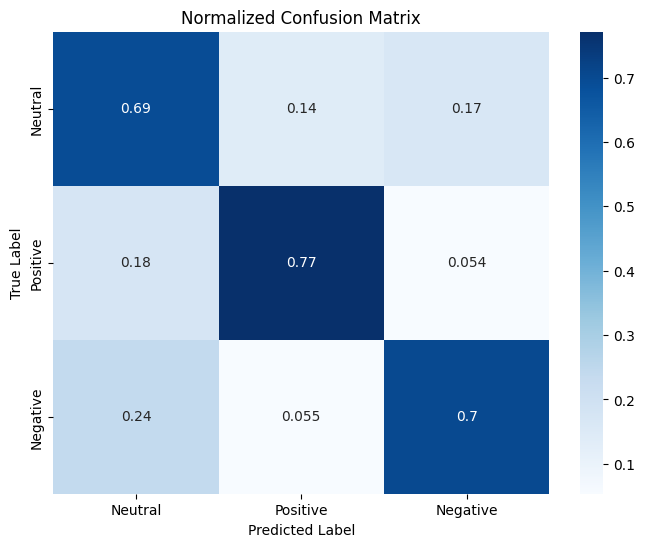

In [14]:
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=['Neutral', 'Positive', 'Negative'], yticklabels=['Neutral', 'Positive', 'Negative'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Step 14:Sentiment Prediction for User Input in Different Languages

In [16]:
language = input("Enter the language: ")
encoder = LaserEncoderPipeline(lang=language)


# Now, you can use the trained model to predict the sentiment of user input
user_text = input("Enter a text: ")
user_text_embedding = encoder.encode_sentences([user_text])[0]
user_text_embedding = np.reshape(user_text_embedding, (1, -1))

predicted_sentiment = np.argmax(model.predict(user_text_embedding))
predicted_sentiment_no = label_encoder.inverse_transform([predicted_sentiment])[0]
if predicted_sentiment_no == 1:
  predicted_sentiment_label = 'neutral'
elif predicted_sentiment_no == 2:
  predicted_sentiment_label = 'positive'
else:
  predicted_sentiment_label = 'negative'

print(f"Predicted Sentiment: {predicted_sentiment_label}")

Enter the language: english
Enter a text: hello
1/1 [==============================] - 0s 35ms/step
Predicted Sentiment: neutral


## Step 15:Sentiment Prediction for Multilingual Texts

This step involves iterating through a collection of sentiments expressed in various languages, including English, Hindi, Portuguese, Romanian, Slovenian, Chinese, French, Dutch, Russian, Italian, and Bosnian.

This process demonstrates the model's ability to analyze sentiments across diverse linguistic contexts and still yeild same output.

In [17]:
sentiments = {
    "english": "So sad, I'll miss you here in San Diego!!!",
    'hindi': 'बहुत दुखद, मैं तुम्हें यहां सैन डिएगो में याद करूंगा!!!',
    'portuguese': 'Tão TRISTE, sentirei sua falta aqui em San Diego!!!',
    'romanian': 'Atat de trist, o sa-mi fie dor de tine aici in San Diego!!!',
    'slovenian': 'Tako žalostno, pogrešal te bom tukaj v San Diegu!!!',
    'chinese': '很傷心，我會在聖地牙哥想念你！',
    'french': 'Tellement triste tu vas me manquer ici à San Diego !!!',
    'dutch': 'Zo verdrietig, ik zal je missen hier in San Diego!!!',
    'russian': 'Ооочень грустно, я буду скучать по тебе здесь, в Сан-Диего!!!',
    'italian': 'Così triste, mi mancherai qui a San Diego!!!',
    'bosnian': 'Tužno, nedostajaćeš mi ovde u San Dijegu!!!'
}

# Iterate through the dictionary and extract values
for language, sentiment in sentiments.items():
  print(f"{language.capitalize()}: {sentiment}")
  encoder = LaserEncoderPipeline(lang=language)
  # Now, you can use the trained model to predict the sentiment of user input
  user_text = sentiment
  user_text_embedding = encoder.encode_sentences([user_text])[0]
  user_text_embedding = np.reshape(user_text_embedding, (1, -1))

  predicted_sentiment = np.argmax(model.predict(user_text_embedding))
  predicted_sentiment_no = label_encoder.inverse_transform([predicted_sentiment])[0]
  if predicted_sentiment_no == 1:
    predicted_sentiment_label = 'neutral'
  elif predicted_sentiment_no == 2:
    predicted_sentiment_label = 'positive'
  else:
    predicted_sentiment_label = 'negative'

  print(f"Predicted Sentiment: {predicted_sentiment_label}")

English: So sad, I'll miss you here in San Diego!!!
1/1 [==============================] - 0s 19ms/step
Predicted Sentiment: negative
Hindi: बहुत दुखद, मैं तुम्हें यहां सैन डिएगो में याद करूंगा!!!


100%|██████████| 608M/608M [00:26<00:00, 23.0MB/s]


1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/fairseq/models/transformer/transformer_encoder.py:281: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  x = torch._nested_tensor_from_mask(


Predicted Sentiment: negative
Portuguese: Tão TRISTE, sentirei sua falta aqui em San Diego!!!
1/1 [==============================] - 0s 20ms/step
Predicted Sentiment: negative
Romanian: Atat de trist, o sa-mi fie dor de tine aici in San Diego!!!
1/1 [==============================] - 0s 22ms/step
Predicted Sentiment: negative
Slovenian: Tako žalostno, pogrešal te bom tukaj v San Diegu!!!
1/1 [==============================] - 0s 18ms/step
Predicted Sentiment: negative
Chinese: 很傷心，我會在聖地牙哥想念你！
1/1 [==============================] - 0s 18ms/step
Predicted Sentiment: negative
French: Tellement triste tu vas me manquer ici à San Diego !!!
1/1 [==============================] - 0s 26ms/step
Predicted Sentiment: negative
Dutch: Zo verdrietig, ik zal je missen hier in San Diego!!!
1/1 [==============================] - 0s 19ms/step
Predicted Sentiment: negative
Russian: Ооочень грустно, я буду скучать по тебе здесь, в Сан-Диего!!!
1/1 [==============================] - 0s 19ms/step
Predicted 

Congratulations! You have completed the sentiment analysis tutorial using LASER embeddings and an RNN. Feel free to experiment with different architectures, hyperparameters, or datasets to further improve the model.